# Analyzing Dinosaur articles on Wikipedia

This notebook is used for analyzing the Wikipedia articles of a large number of dinosaur related articles.
These articles are stored as a csv file in `input/dinosaur_genera.cleaned.SEPT.2022.csv`.

## 1. Fetching and Preprocessing the data
First we import the necessary modules.

In [89]:
# 
# These are standard python modules
import json, time, urllib.parse
import copy
import datetime as dt

#
# The modules below are not a standard Python module. You will need to install them with pip/pip3 if you do not already have it
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

We define a class for making api requests to the [Wikimedia pageviews API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). 

In [78]:
class APIRequest(object):
    def __init__(self) -> None:
        self.endpoint_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
        self.endpoint_params = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
        self.request_headers = {
            'User-Agent': 'abhis1@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2022',
        }
        self.API_LATENCY_ASSUMED = 0.002
        self.API_THROTTLE_WAIT = (1.0/100.0) - self.API_LATENCY_ASSUMED

    def fetch(self, article_title, params_template):
        # Make sure we have an article title
        if not article_title: return None

        # Titles are supposed to have spaces replaced with "_" and be URL encoded
        article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
        params_template['article'] = article_title_encoded

        # now, create a request URL by combining the endpoint_url with the parameters for the request
        request_url = self.endpoint_url + self.endpoint_params.format(**params_template)

        # make the request
        try:
            # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
            # occurs during the request processing - throttling is always a good practice with a free
            # data source like Wikipedia - or other community sources
            if self.API_THROTTLE_WAIT > 0.0:
                pass
                # time.sleep(self.API_THROTTLE_WAIT)
            response = requests.get(request_url, headers=self.request_headers)
            json_response = response.json()
        except Exception as e:
            print(e)
            json_response = None
        return json_response

Next, we define functions that will be used during the preprocessing stage.  

The function `drop_access` drops the 'access' key of the dictionary since we will not be using it.  

The function `merge` merges two sources of data by adding the 'views' together.
This is used to merge mobile-app and mobile-web together into a single mobile dataset.
It is also used to merge mobile and desktop to create a cumulative dataset.

In [79]:
def drop_access(resp):
    items = resp['items']
    new_items = []
    for item in items:
        item.pop('access', None)
        new_items.append(item)
    resp['items'] = new_items
    return resp


def merge(data_mobile_app, data_mobile_web):
    app_items = data_mobile_app['items']
    web_items = data_mobile_web['items']
    new_items = []
    for app_item, web_item in zip(app_items, web_items):
        new_app_item = copy.deepcopy(app_item)
        new_app_item['views'] = app_item['views'] + web_item['views']
        new_items.append(new_app_item)
    new_resp = {}
    new_resp['items'] = new_items
    return new_resp

The `params_template` is used to format the request url which will be called by an instance of `APIRequest` object.

In [80]:
params_template = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",
    "end":         "2023010100"    # this is likely the wrong end date
}

We load the list of dinosaurs from the file `input/dinosaur_genera.cleaned.SEPT.2022.csv` 

In [81]:
dino_list = pd.read_csv('../input/dinosaur_genera.cleaned.SEPT.2022.csv')
article_titles = list(dino_list['name'])

We initialize the `api_requester` and define empty dictionaries that will be used to store and save the data.

In [82]:
api_requester = APIRequest()

final_mobile_dict = {}
final_desktop_dict = {}
final_cumulative_dict = {}

For each article title we fetch the details of that article, preprocess it and add it to the dictionary to store that data

In [84]:
for article_title in tqdm(article_titles[:10]):
    params_template['access'] = "desktop"
    data_desktop = api_requester.fetch(article_title, params_template)
    data_desktop = drop_access(data_desktop)

    params_template['access'] = "mobile-app"
    data_mobile_app = api_requester.fetch(article_title, params_template)
    data_mobile_app = drop_access(data_mobile_app)

    params_template['access'] = "mobile-web"
    data_mobile_web = api_requester.fetch(article_title, params_template)
    data_mobile_web = drop_access(data_mobile_web)

    data_mobile = merge(data_mobile_app, data_mobile_web)

    data_cumulative = merge(data_mobile, data_desktop)

    final_desktop_dict[article_title] = data_desktop
    final_mobile_dict[article_title] = data_mobile
    final_cumulative_dict[article_title] = data_cumulative

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Save the dictionary as json in the `data` folder

In [85]:
with open(f"../data/dino_monthly_desktop_start201501_end202210.json", 'w') as f:
    json.dump(final_desktop_dict, f)

with open(f"../data/dino_monthly_mobile_start201501_end202210.json", 'w') as f:
    json.dump(final_mobile_dict, f)

with open(f"../data/dino_monthly_cumulative_start201501_end202210.json", 'w') as f:
    json.dump(final_mobile_dict, f)

## 2. Analysis

Let us load the saved data for our analysis. This is the same data that we saved in the previous step.



In [86]:
with open(f"../data/dino_monthly_desktop_start201501_end202210.json", 'r') as f:
    data_desktop = json.load(f)

with open(f"../data/dino_monthly_mobile_start201501_end202210.json", 'r') as f:
    data_mobile = json.load(f)

with open(f"../data/dino_monthly_cumulative_start201501_end202210.json", 'r') as f:
    data_cumulative = json.load(f)

### 2.1 Maximum Average and Minimum Average

First we get the article titles of the pages that had the maximum average and minimum average pageviews across desktop and mobile.  

Functions `get_max_average` and `get_min_average` return the title of the article that have the maximum and minumum average pageviews respectively. `get_item_stats` is a helper function used to calculate the counts and pageviews of each article.  

We get these titles across both mobile and desktop to get four such titles.

In [90]:
def get_item_stats(items):
    count = 0
    pageviews = 0
    for item in items:
        count += 1
        pageviews += item['views']
    return count, pageviews
    

def get_max_average(data):
    max_title = ""
    max_avg_pageviews = 0
    for article_title, items in data.items():
        count, pageviews = get_item_stats(items['items'])
        avg = pageviews/count
        if avg > max_avg_pageviews:
            max_title = article_title
            max_avg_pageviews = avg
    return max_title


def get_min_average(data):
    min_title = ""
    min_avg_pageviews = float("inf")
    for article_title, items in data.items():
        count, pageviews = get_item_stats(items['items'])
        avg = pageviews/count
        if avg < min_avg_pageviews:
            min_title = article_title
            min_avg_pageviews = avg
    return min_title

max_title_desktop = get_max_average(data_desktop)
min_title_desktop = get_min_average(data_desktop)
max_title_mobile = get_max_average(data_mobile)
min_title_mobile = get_min_average(data_mobile)

Once, we have the articles, we next get the time series data of pageviews corresponding to those articles.
The function `convert_data_to_ts` is used to get this data in the correct format for plotting it.

In [91]:
def convert_data_to_ts(data, title):
    items = data[title]['items']
    ts = []
    views = []
    for item in items:
        timestamp = dt.datetime.strptime(item['timestamp'], "%Y%m%d00")
        ts.append(timestamp)
        views.append(item['views'])

    return ts, views


ts_max_desktop, views_max_desktop = convert_data_to_ts(data_desktop, max_title_desktop)
ts_min_desktop, views_min_desktop = convert_data_to_ts(data_desktop, min_title_desktop)
ts_max_mobile, views_max_mobile = convert_data_to_ts(data_mobile, max_title_mobile)
ts_min_mobile, views_min_mobile = convert_data_to_ts(data_mobile, min_title_mobile)

Next, we define a function to plot the pageviews as a time series.

In [106]:
def plot_graphs(ts_list, views_list, legend_list, title, filepath):
    color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:gray", "tab:olive", "tab:cyan", "tab:pink",
    "aquamarine", "antiquewhite", "gold", "greenyellow", "darkgreen", "darkolivegreen", "deepskyblue", "darkmagenta", "fuchsia", "goldenrod"]
    for i in range(len(ts_list)):
        ts = ts_list[i]
        views = views_list[i]
        legend = legend_list[i]
        color = color_list[i]
        plt.rcParams['figure.figsize'] = [12, 6]
        plt.yscale('log')
        plt.title(title)
        plt.plot(ts, views, color=color, label=legend)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.tight_layout()
    plt.savefig(filepath, dpi=100)
    plt.show()
    

Now, we will call `plot_graphs` to plot and save the graph of time series of the pageviews for these 4 articles.

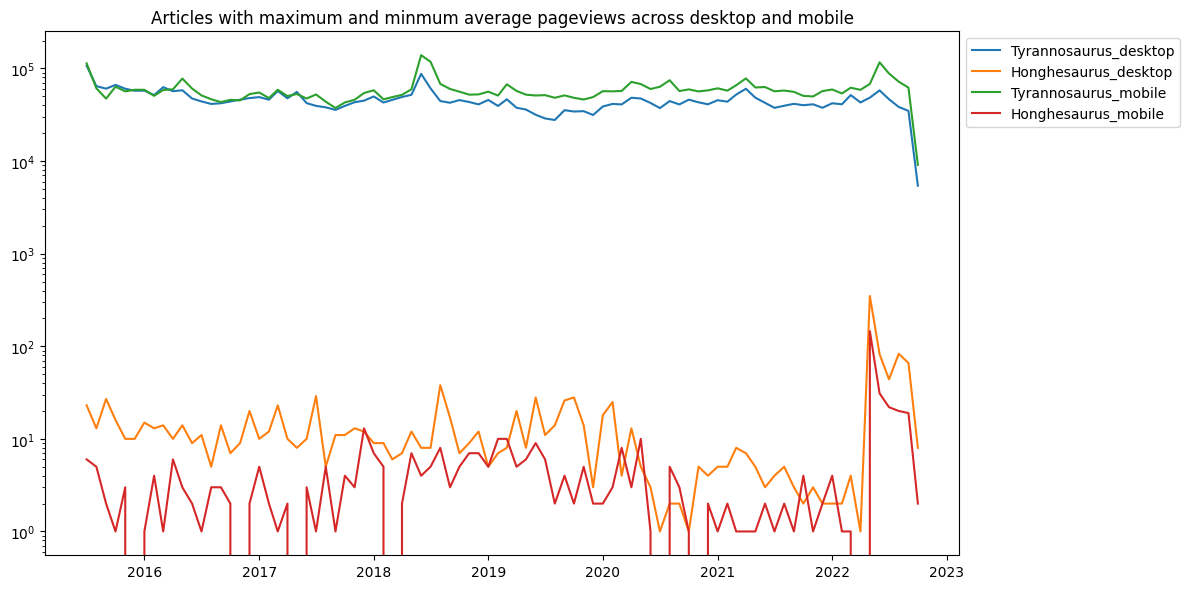

In [107]:
ts_list = [ts_max_desktop, ts_min_desktop, ts_max_mobile, ts_min_mobile]
views_list = [views_max_desktop, views_min_desktop, views_max_mobile, views_min_mobile]
legend_list = [max_title_desktop+"_desktop", min_title_desktop+"_desktop", max_title_mobile+"_mobile", min_title_mobile+"_mobile"]

plot_graphs(ts_list, views_list, legend_list, "Articles with maximum and minmum average pageviews across desktop and mobile", "../images/figure1.png")

### 2.2 Top 10 Peak Page Views

Now, we first define the function `get_top_10_peaks` to get the 10 articles with the highest peaks in pageviews. `get_peak_views` is a helper function to get the peak views for a given article.  

We get the top 10 such articles for both desktop and mobile.

In [108]:
def get_peak_views(items):
    peak_views = 0
    for item in items:
        peak_views = max(peak_views, item['views'])
    return peak_views


def get_top_10_peaks(data):
    article_titles = []
    peaks = []
    for article_title, items in data.items():
        peak_views = get_peak_views(items['items'])
        article_titles.append(article_title)
        peaks.append(peak_views)

    peaks, article_titles = zip(*sorted(zip(peaks, article_titles), reverse=True))

    return article_titles[:10]

top_10_peak_articles_desktop = get_top_10_peaks(data_desktop)
top_10_peak_articles_mobile = get_top_10_peaks(data_mobile)

Next for the 20 articles, we got in the previous step, we get the timeseries and pageviews data which we will need to plot.

In [109]:
ts_top_10_desktop, views_top_10_desktop = zip(*[convert_data_to_ts(data_desktop, article_title) for article_title in top_10_peak_articles_desktop])
ts_top_10_mobile, views_top_10_mobile = zip(*[convert_data_to_ts(data_mobile, article_title) for article_title in top_10_peak_articles_mobile])

legend_top_10_desktop = [f"desktop_no_{i}_{elem}" for i, elem in enumerate(top_10_peak_articles_desktop)]
legend_top_10_mobile = [f"mobile_no_{i}_{elem}" for i, elem in enumerate(top_10_peak_articles_mobile)]

Now, we will call `plot_graphs` to plot and save the graph of time series of the pageviews for these 20 articles.

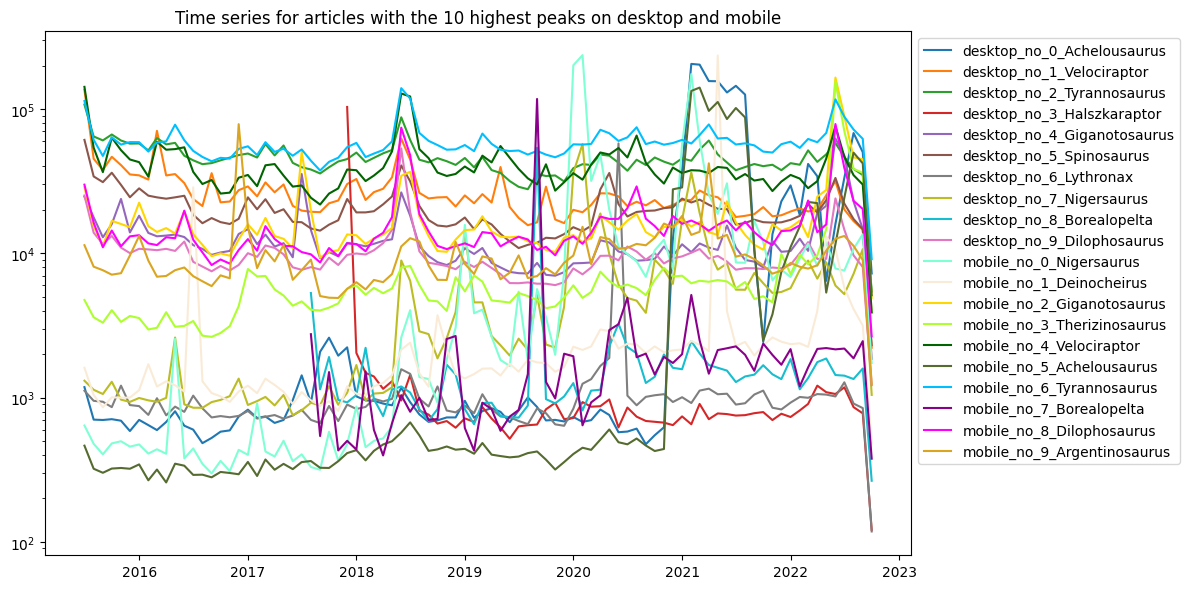

In [110]:
ts_list = ts_top_10_desktop + ts_top_10_mobile
views_list = views_top_10_desktop + views_top_10_mobile
legend_list = legend_top_10_desktop + legend_top_10_mobile

plot_graphs(ts_list, views_list, legend_list, "Time series for articles with the 10 highest peaks on desktop and mobile", "../images/figure2.png")

### 2.3 Fewest Months of Data

Now, we first define the function `get_top_10_fewest_months` to get the 10 articles with the fewest months of data.  

We get the top 10 such articles for both desktop and mobile.

In [111]:
def get_top_10_fewest_months(data):
    article_titles = []
    count_months = []
    for article_title, items in data.items():
        article_titles.append(article_title)
        count_months.append(len(items['items']))

    count_months, article_titles = zip(*sorted(zip(count_months, article_titles)))

    return article_titles[:10]

top_10_fewest_months_desktop = get_top_10_fewest_months(data_desktop)
top_10_fewest_months_mobile = get_top_10_fewest_months(data_mobile)

Next for the 20 articles, we got in the previous step, we get the timeseries and pageviews data which we will need to plot.

In [112]:
ts_top_10_fewest_desktop, views_top_10_fewest_desktop = zip(*[convert_data_to_ts(data_desktop, article_title) for article_title in top_10_fewest_months_desktop])
ts_top_10_fewest_mobile, views_top_10_fewest_mobile = zip(*[convert_data_to_ts(data_mobile, article_title) for article_title in top_10_fewest_months_mobile])

legend_top_10_fewest_desktop = [f"desktop_no_{i}_{elem}" for i, elem in enumerate(top_10_fewest_months_desktop)]
legend_top_10_mobile = [f"mobile_no_{i}_{elem}" for i, elem in enumerate(top_10_fewest_months_mobile)]

Now, we will call `plot_graphs` to plot and save the graph of time series of the pageviews for these 20 articles.

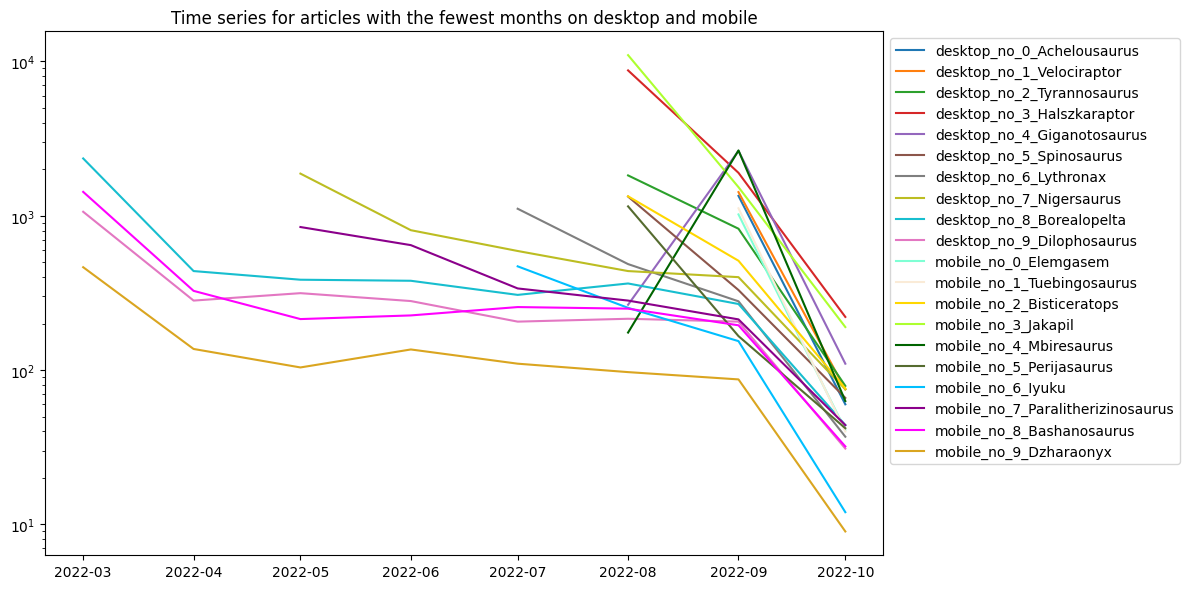

In [113]:
ts_list = ts_top_10_fewest_desktop + ts_top_10_fewest_mobile
views_list = views_top_10_fewest_desktop + views_top_10_fewest_mobile
legend_list = legend_top_10_desktop + legend_top_10_mobile

plot_graphs(ts_list, views_list, legend_list, "Time series for articles with the fewest months on desktop and mobile", "../images/figure3.png")